In [1]:
import os
import pandas as pd
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize

In [2]:
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras import  models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

In [3]:
image_dir = os.path.dirname(os.getcwd())+"\\Screenshots\\InContext\\"
filenames = os.listdir(image_dir)
labels = [x.split("_")[0] for x in filenames]
img = [imread(image_dir + x) for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels, "img": img})

for index, row in data.iterrows():
    img = imread(image_dir + row["filename"])
    img = resize(img, (80,80))
    data.loc[index, "img"] = img

data = data.reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     1440 non-null   int64 
 1   filename  1440 non-null   object
 2   label     1440 non-null   object
 3   img       1440 non-null   object
dtypes: int64(1), object(3)
memory usage: 45.1+ KB


In [4]:
#Splitting the data into training and testing
train_df, test_df = train_test_split(data, test_size=0.3)

# Datagen for training data. Augment the data by rotating, shifting, flipping, to make the model more robust and less prone to overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
    directory=image_dir,
    target_size=(64, 64),
    x_col='filename',
    y_col='label',
    batch_size=32,
    class_mode='categorical'  # or 'categorical' based on your problem
)



Found 1008 validated image filenames belonging to 5 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode= "categorical"  # or 'categorical'
)

Found 432 validated image filenames belonging to 5 classes.


In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input_shape based on your image dimensions
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # or more units with 'softmax' for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_initial = model.fit(train_generator,validation_data = test_generator, epochs=30)

C:\Users\Merved\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


C:\Users\Merved\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.3000 - loss: 1.7084 - val_accuracy: 0.7986 - val_loss: 0.5603
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.7575 - loss: 0.6152 - val_accuracy: 0.8889 - val_loss: 0.3721
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8808 - loss: 0.3041 - val_accuracy: 0.9190 - val_loss: 0.1933
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9463 - loss: 0.1689 - val_accuracy: 0.9144 - val_loss: 0.3865
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9421 - loss: 0.1564 - val_accuracy: 0.9097 - val_loss: 0.3853
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9764 - loss: 0.0844 - val_accuracy: 0.8912 - val_loss: 1.0180
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9435 - loss: 0.1741 - val_accuracy: 0.9167 - val_loss: 0.3112
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9734 - loss: 0.0780 - val_accuracy: 0.9051 - val_

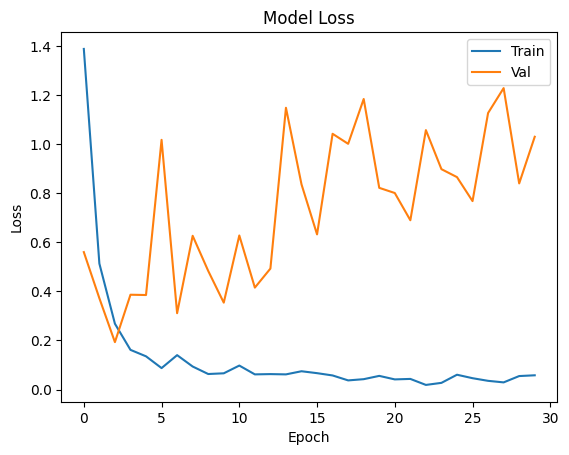

In [7]:
def plot_model_loss(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

plot_model_loss(trained_model_initial)

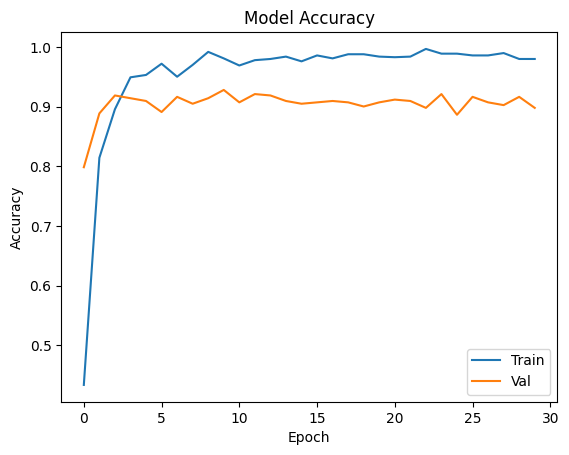

In [8]:
def plot_model_acc(model):
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

plot_model_acc(trained_model_initial)

In [24]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input_shape based on your image dimensions
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # or more units with 'softmax' for multi-class classification
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_reduced_lr = model.fit(train_generator,validation_data = test_generator, epochs=30)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.2693 - loss: 1.6109 - val_accuracy: 0.4606 - val_loss: 1.2996
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.4888 - loss: 1.2756 - val_accuracy: 0.7431 - val_loss: 0.8887
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.6434 - loss: 0.9533 - val_accuracy: 0.8079 - val_loss: 0.6415
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.7325 - loss: 0.8071 - val_accuracy: 0.8542 - val_loss: 0.5277
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.7899 - loss: 0.6429 - val_accuracy: 0.8264 - val_loss: 0.4614
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.8242 - loss: 0.5514 - val_accuracy: 0.8380 - val_loss: 0.4688
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.8660 - loss: 0.4714 - val_accuracy: 0.8935 - val_loss: 0.3147
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.8615 - loss: 0.4405 - val_accuracy: 0.

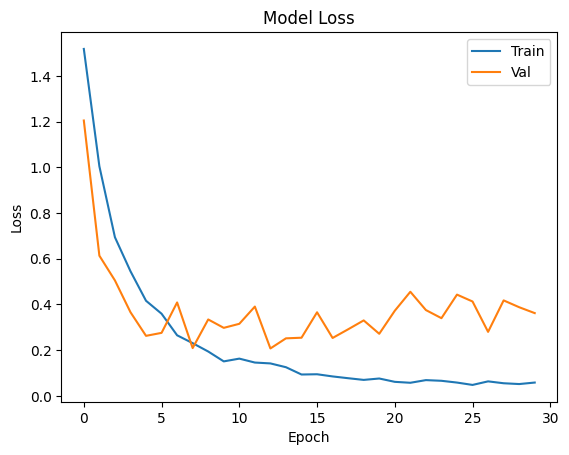

In [23]:
plot_model_loss(trained_model_reduced_lr)

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input_shape based on your image dimensions
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # or more units with 'softmax' for multi-class classification
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_inc_epochs = model.fit(train_generator,validation_data = test_generator, epochs=60)

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.2572 - loss: 1.5747 - val_accuracy: 0.6366 - val_loss: 1.1986
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.5086 - loss: 1.2410 - val_accuracy: 0.7847 - val_loss: 0.7967
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.6989 - loss: 0.8884 - val_accuracy: 0.8681 - val_loss: 0.5398
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.7837 - loss: 0.6581 - val_accuracy: 0.8588 - val_loss: 0.4235
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.8166 - loss: 0.5434 - val_accuracy: 0.8403 - val_loss: 0.4249
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.7962 - loss: 0.5374 - val_accuracy: 0.9144 - val_loss: 0.2760
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.8971 - loss: 0.3565 - val_accuracy: 0.9051 - val_loss: 0.3008
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9338 - loss: 0.2872 - val_accuracy: 0

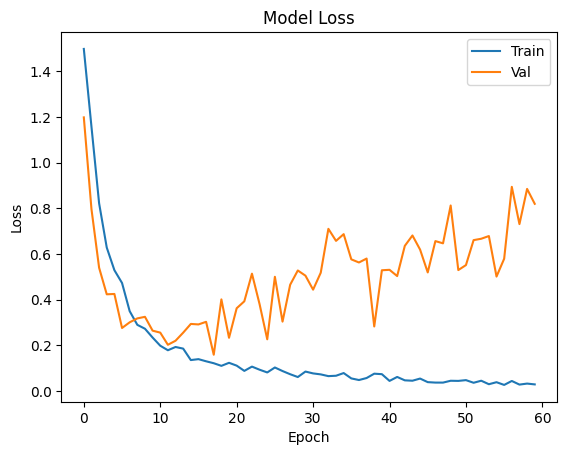

In [12]:
plot_model_loss(trained_model_inc_epochs)

In [13]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input_shape based on your image dimensions
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # or more units with 'softmax' for multi-class classification
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_simplified = model.fit(train_generator,validation_data = test_generator, epochs=60)

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.2277 - loss: 1.6113 - val_accuracy: 0.4005 - val_loss: 1.5192
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.3487 - loss: 1.5221 - val_accuracy: 0.3634 - val_loss: 1.4075
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.4448 - loss: 1.4095 - val_accuracy: 0.8588 - val_loss: 1.1538
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.5960 - loss: 1.2464 - val_accuracy: 0.7315 - val_loss: 0.9903
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.6435 - loss: 1.0836 - val_accuracy: 0.6852 - val_loss: 0.8547
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.6301 - loss: 0.9682 - val_accuracy: 0.8356 - val_loss: 0.6805
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.7704 - loss: 0.8387 - val_accuracy: 0.8611 - val_loss: 0.6090
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.8160 - loss: 0.7171 - val_accuracy: 0.

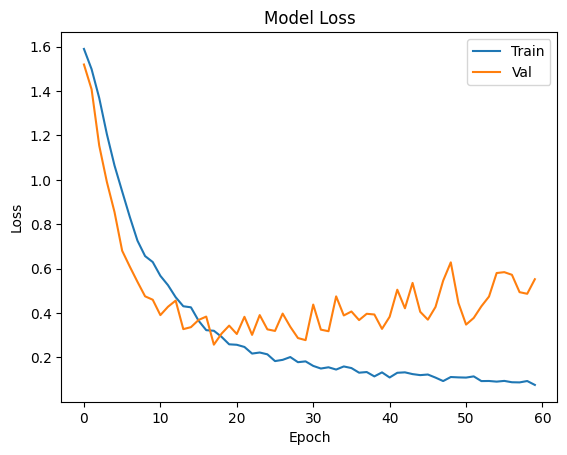

In [14]:
plot_model_loss(trained_model_simplified)

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input_shape based on your image dimensions
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')  # or more units with 'softmax' for multi-class classification
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_remove_layer = model.fit(train_generator,validation_data = test_generator, epochs=60)

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.2709 - loss: 1.6565 - val_accuracy: 0.4028 - val_loss: 1.2235
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.5084 - loss: 1.2337 - val_accuracy: 0.6968 - val_loss: 0.9575
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.6289 - loss: 1.0315 - val_accuracy: 0.8264 - val_loss: 0.8720
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.6536 - loss: 0.9102 - val_accuracy: 0.7778 - val_loss: 0.6514
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7781 - loss: 0.7246 - val_accuracy: 0.8588 - val_loss: 0.5846
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.7813 - loss: 0.6584 - val_accuracy: 0.8403 - val_loss: 0.5578
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8703 - loss: 0.5596 - val_accuracy: 0.8449 - val_loss: 0.4842
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.8102 - loss: 0.5611 - val_accuracy: 0.

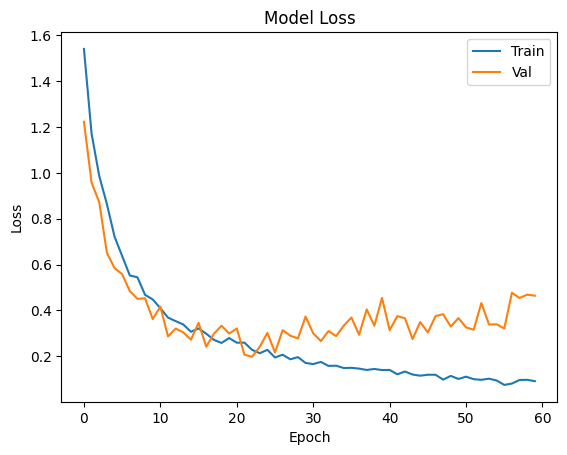

In [16]:
plot_model_loss(trained_model_remove_layer)

In [17]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input_shape based on your image dimensions
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')  # or more units with 'softmax' for multi-class classification
])

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_inc_lr = model.fit(train_generator,validation_data = test_generator, epochs=60)

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.3275 - loss: 1.5795 - val_accuracy: 0.8750 - val_loss: 0.7888
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.7203 - loss: 0.8722 - val_accuracy: 0.7384 - val_loss: 0.6146
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8152 - loss: 0.6273 - val_accuracy: 0.8611 - val_loss: 0.4144
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8888 - loss: 0.4385 - val_accuracy: 0.8657 - val_loss: 0.4409
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.8750 - loss: 0.3899 - val_accuracy: 0.8773 - val_loss: 0.3307
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9086 - loss: 0.3388 - val_accuracy: 0.8889 - val_loss: 0.3233
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.9192 - loss: 0.3190 - val_accuracy: 0.9005 - val_loss: 0.2454
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - accuracy: 0.9180 - loss: 0.2764 - val_accuracy: 0.

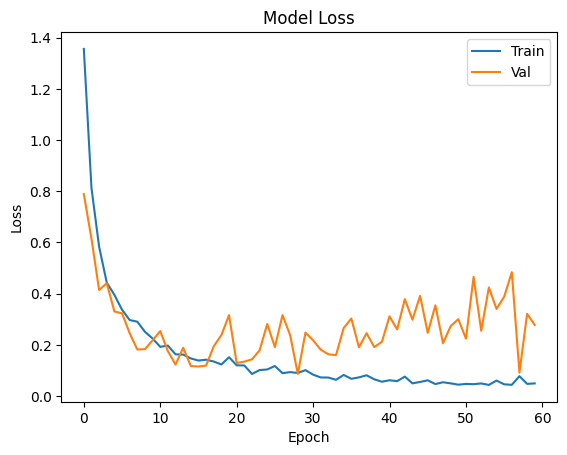

In [33]:
plot_model_loss(trained_model_inc_lr)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


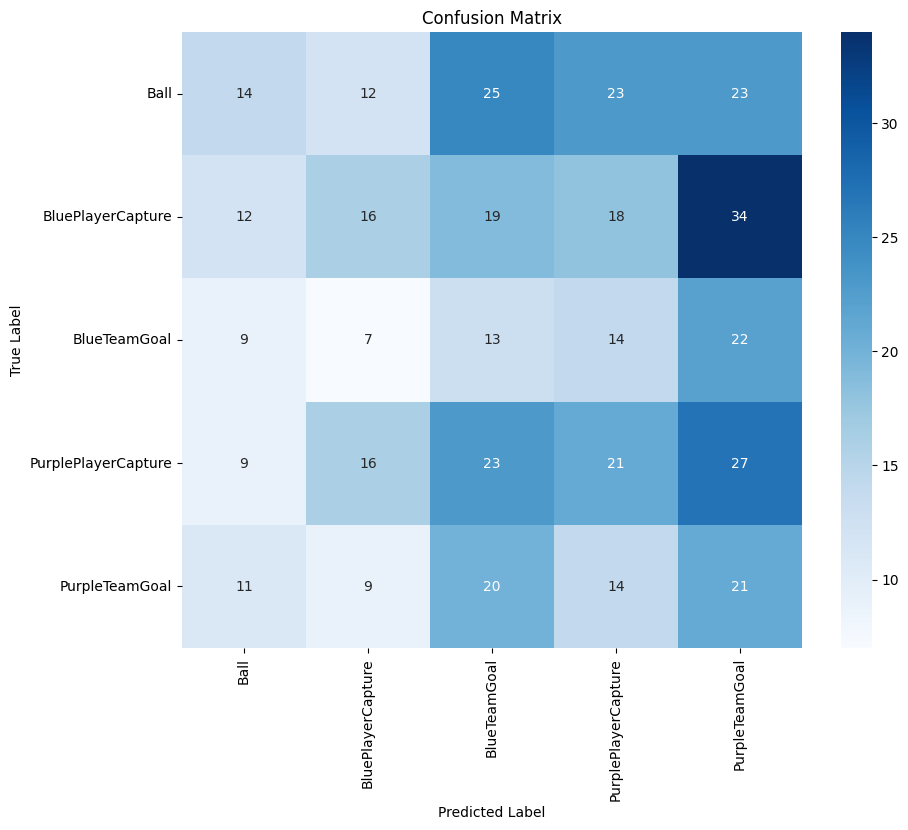

In [43]:
from sklearn.metrics import confusion_matrix
test_labels = test_generator.classes

# Predict the probabilities on the test data
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
model.save('trained_model_inc_lr.h5')

In [27]:
from keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_test = model.fit(train_generator,validation_data = test_generator, epochs=60)

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.4804 - loss: 6.6177 - val_accuracy: 0.3611 - val_loss: 6.5450
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.7928 - loss: 5.4790 - val_accuracy: 0.4236 - val_loss: 6.8290
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.8423 - loss: 5.1922 - val_accuracy: 0.4259 - val_loss: 6.9969
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.8937 - loss: 4.8762 - val_accuracy: 0.4398 - val_loss: 7.0127
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9029 - loss: 4.6928 - val_accuracy: 0.3681 - val_loss: 6.8919
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.9083 - loss: 4.5206 - val_accuracy: 0.4074 - val_loss: 6.7420
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.9277 - loss: 4.2945 - val_accuracy: 0.4398 - val_loss: 6.1690
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9401 - loss: 4.0511 - val_accuracy: 0

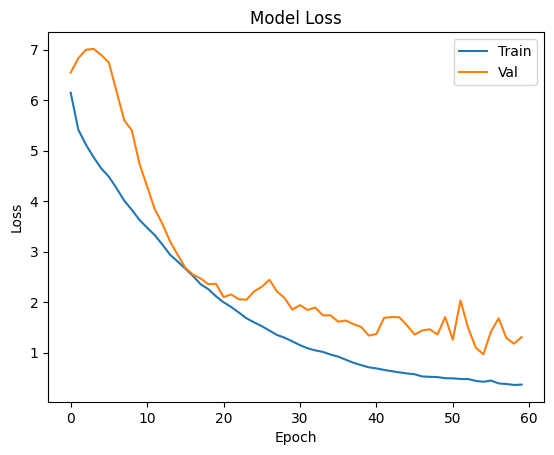

In [28]:
plot_model_loss(trained_model_test)

In [29]:
from keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_test2 = model.fit(train_generator,validation_data = test_generator, epochs=40)

C:\Users\Merved\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.5531 - loss: 6.2766 - val_accuracy: 0.6181 - val_loss: 5.3286
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.7885 - loss: 4.5458 - val_accuracy: 0.5972 - val_loss: 4.8671
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.8496 - loss: 4.0662 - val_accuracy: 0.6019 - val_loss: 4.5358
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9024 - loss: 3.6994 - val_accuracy: 0.5787 - val_loss: 4.3327
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.9253 - loss: 3.4784 - val_accuracy: 0.6458 - val_loss: 3.9767
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9464 - loss: 3.1902 - val_accuracy: 0.5903 - val_loss: 3.8170
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.9354 - loss: 2.9998 - val_accuracy: 0.7315 - val_loss: 3.4318
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - accuracy: 0.9429 - loss: 2.7966 - val_accuracy

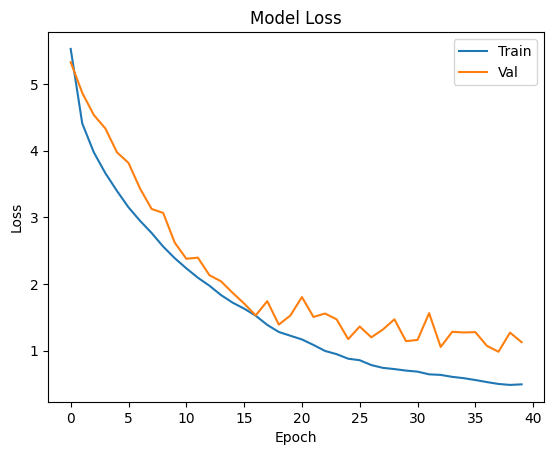

In [30]:
plot_model_loss(trained_model_test2)

In [31]:
from keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    #Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    #Dropout(0.4),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_test3 = model.fit(train_generator,validation_data = test_generator, epochs=40)

C:\Users\Merved\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.6136 - loss: 5.8844 - val_accuracy: 0.4421 - val_loss: 5.2712
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.8784 - loss: 4.3120 - val_accuracy: 0.6574 - val_loss: 4.6314
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.9038 - loss: 3.8238 - val_accuracy: 0.6458 - val_loss: 4.2672
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.9283 - loss: 3.3923 - val_accuracy: 0.7755 - val_loss: 3.8373
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - accuracy: 0.9161 - loss: 3.1324 - val_accuracy: 0.6875 - val_loss: 3.6623
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.9443 - loss: 2.7618 - val_accuracy: 0.7176 - val_loss: 3.3061
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.9644 - loss: 2.4913 - val_accuracy: 0.7546 - val_loss: 2.9536
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - accuracy: 0.9634 - loss: 2.2439 - val_accu

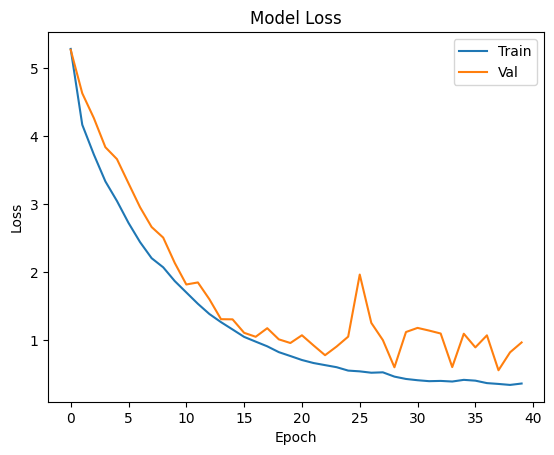

In [32]:
plot_model_loss(trained_model_test3)

In [34]:
from keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.15),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0004), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_test2 = model.fit(train_generator,validation_data = test_generator, epochs=60)

Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.5875 - loss: 6.0080 - val_accuracy: 0.2870 - val_loss: 5.7796
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.8840 - loss: 4.1844 - val_accuracy: 0.3773 - val_loss: 4.6292
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.9070 - loss: 3.5119 - val_accuracy: 0.4028 - val_loss: 3.9168
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9403 - loss: 2.9283 - val_accuracy: 0.5440 - val_loss: 3.3323
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.9353 - loss: 2.4804 - val_accuracy: 0.5532 - val_loss: 2.9373
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9548 - loss: 2.0898 - val_accuracy: 0.5602 - val_loss: 2.5919
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9504 - loss: 1.8349 - val_accuracy: 0.7963 - val_loss: 2.1994
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.9527 - loss: 1.5242 - val_accuracy:

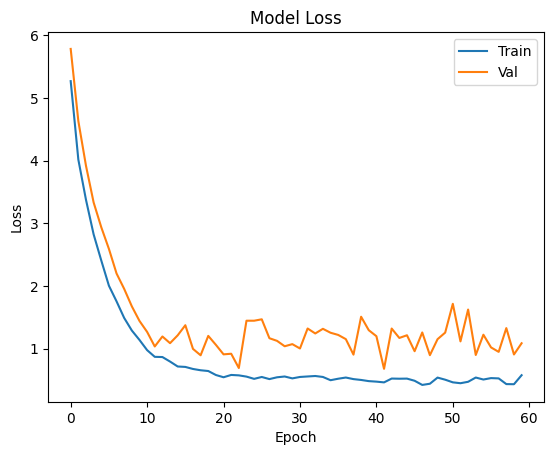

In [35]:
plot_model_loss(trained_model_test2)

In [40]:
from keras.layers import BatchNormalization

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.15),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0004), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_test4 = model.fit(train_generator,validation_data = test_generator, epochs=30)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.5659 - loss: 3.5692 - val_accuracy: 0.4190 - val_loss: 3.0967
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.8842 - loss: 2.2876 - val_accuracy: 0.4745 - val_loss: 2.8921
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9080 - loss: 1.9962 - val_accuracy: 0.4375 - val_loss: 2.8479
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.9520 - loss: 1.7352 - val_accuracy: 0.4606 - val_loss: 2.7032
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.9473 - loss: 1.5332 - val_accuracy: 0.5440 - val_loss: 2.4012
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9298 - loss: 1.4816 - val_accuracy: 0.4745 - val_loss: 2.3199
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.9432 - loss: 1.3380 - val_accuracy: 0.5208 - val_loss: 2.3065
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.9631 - loss: 1.1727 - val_accuracy: 0.

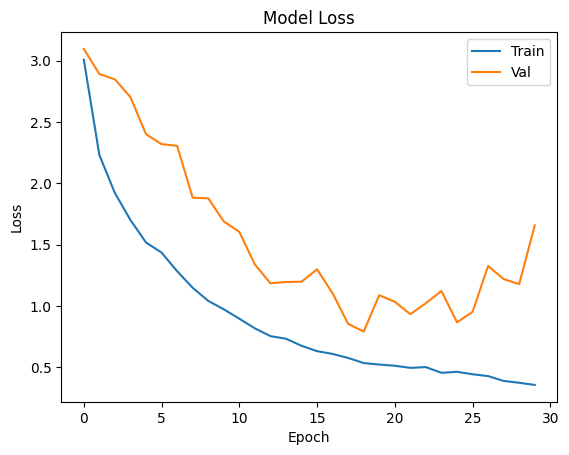

In [41]:
plot_model_loss(trained_model_test4)